In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy import fftpack
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import optuna

In [22]:
# Load the dataset
full_data = pd.read_parquet("/content/drive/MyDrive/ml4qs/full_dataset_pre.parquet.gzip")
full_data = full_data[full_data["SM_platform"] != "Red"]

In [23]:
# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]


In [24]:
# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]


In [25]:
# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

In [26]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [27]:
# Optuna objective function for hyperparameter tuning
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'num_class': len(label_encoder.classes_),
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
    dtest = xgb.DMatrix(X_test, label=y_test_encoded)
    cv_results = xgb.cv(param, dtrain, num_boost_round=1000, nfold=5,
                        early_stopping_rounds=10, metrics='mlogloss', seed=42)

    return cv_results['test-mlogloss-mean'].min()


In [28]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-06-21 11:35:27,598] A new study created in memory with name: no-name-15e8504b-e321-4243-9add-e4876b97c5b1
[I 2024-06-21 11:39:46,314] Trial 0 finished with value: 0.0016664418757539319 and parameters: {'max_depth': 5, 'eta': 0.087032154691288, 'subsample': 0.5002718172610633, 'colsample_bytree': 0.61500281089396, 'lambda': 4.389528739224633e-06, 'alpha': 4.759524820314444e-05}. Best is trial 0 with value: 0.0016664418757539319.
[I 2024-06-21 11:42:51,476] Trial 1 finished with value: 0.001562910738717882 and parameters: {'max_depth': 6, 'eta': 0.13662472138681803, 'subsample': 0.9206899770442027, 'colsample_bytree': 0.5099627855130587, 'lambda': 1.0214104152600185e-08, 'alpha': 0.021299298737343837}. Best is trial 1 with value: 0.001562910738717882.
[I 2024-06-21 11:45:48,797] Trial 2 finished with value: 0.001746476249539542 and parameters: {'max_depth': 4, 'eta': 0.16116523073454994, 'subsample': 0.5277845511384589, 'colsample_bytree': 0.8836178634162027, 'lambda': 3.41303792

Best hyperparameters:  {'max_depth': 4, 'eta': 0.11322774318302968, 'subsample': 0.9661880393103377, 'colsample_bytree': 0.6378373887316273, 'lambda': 9.065132793615444e-05, 'alpha': 1.164583827491238e-06}


Performance with Default Hyperparameters:
Accuracy: 0.7460083187977995
Classification Report:
              precision    recall  f1-score   support

          FB       0.90      1.00      0.95      5996
       Insta       1.00      1.00      1.00      5951
      Reddit       0.11      0.02      0.04      5955
      TikTok       0.46      0.83      0.59      5955
           X       1.00      0.88      0.94      5955

    accuracy                           0.75     29812
   macro avg       0.69      0.75      0.70     29812
weighted avg       0.69      0.75      0.70     29812

Confusion Matrix:
[[5983   13    0    0    0]
 [   3 5948    0    0    0]
 [   0    1  126 5828    0]
 [   0    0 1019 4935    1]
 [ 633    7    0   67 5248]]
   Feature  Importance
58    pc_3      2182.0
57    pc_2      2041.0
60    pc_5       944.0
59    pc_4       775.0
55   index       708.0


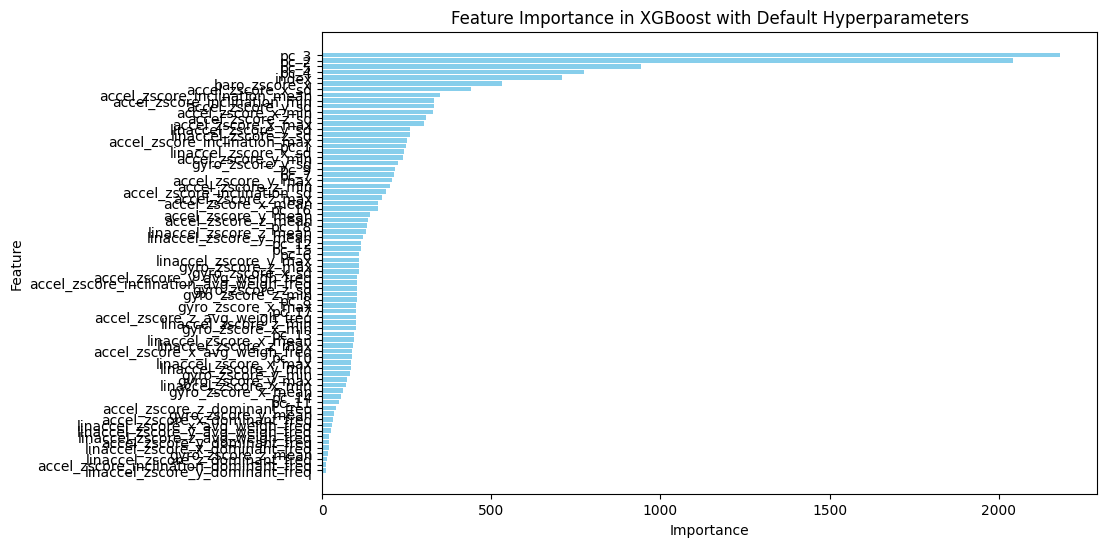

In [33]:
# Train the final model with the default hyperparameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load the dataset
#full_data = pd.read_parquet("Emir_Datasets/full_dataset.parquet.gzip")
full_data = pd.read_parquet("/content/drive/MyDrive/ml4qs/full_dataset_pre.parquet.gzip")
full_data = full_data[full_data["SM_platform"] != "Red"]

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in full_data.columns if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the model with default hyperparameters
default_params = {
    'objective': 'multi:softprob',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'n_estimators': 100
}

dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

default_model = xgb.train(default_params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = default_model.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print("Performance with Default Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Feature importance
importances = default_model.get_score(importance_type='weight')
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost with Default Hyperparameters')
plt.gca().invert_yaxis()
plt.show()


In [29]:
# Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({'objective': 'multi:softprob', 'num_class': len(label_encoder.classes_), 'eval_metric': 'mlogloss'})

dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

final_model = xgb.train(best_params, dtrain, num_boost_round=1000,
                        evals=[(dtest, "Test")], early_stopping_rounds=10)


[0]	Test-mlogloss:1.50147
[1]	Test-mlogloss:1.41635
[2]	Test-mlogloss:1.35583
[3]	Test-mlogloss:1.30284
[4]	Test-mlogloss:1.24348
[5]	Test-mlogloss:1.19936
[6]	Test-mlogloss:1.14862
[7]	Test-mlogloss:1.11679
[8]	Test-mlogloss:1.07783
[9]	Test-mlogloss:1.04107
[10]	Test-mlogloss:1.00752
[11]	Test-mlogloss:0.99177
[12]	Test-mlogloss:0.97789
[13]	Test-mlogloss:0.96037
[14]	Test-mlogloss:0.94489
[15]	Test-mlogloss:0.93387
[16]	Test-mlogloss:0.91354
[17]	Test-mlogloss:0.89492
[18]	Test-mlogloss:0.87804
[19]	Test-mlogloss:0.86387
[20]	Test-mlogloss:0.85150
[21]	Test-mlogloss:0.84168
[22]	Test-mlogloss:0.83638
[23]	Test-mlogloss:0.82519
[24]	Test-mlogloss:0.81430
[25]	Test-mlogloss:0.80762
[26]	Test-mlogloss:0.80237
[27]	Test-mlogloss:0.79095
[28]	Test-mlogloss:0.78929
[29]	Test-mlogloss:0.78170
[30]	Test-mlogloss:0.77701
[31]	Test-mlogloss:0.76901
[32]	Test-mlogloss:0.76427
[33]	Test-mlogloss:0.75739
[34]	Test-mlogloss:0.75764
[35]	Test-mlogloss:0.75264
[36]	Test-mlogloss:0.74543
[37]	Test-m

In [30]:
# Make predictions
y_pred_prob = final_model.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))


Accuracy: 0.740037568764256
Classification Report:
              precision    recall  f1-score   support

          FB       0.83      0.99      0.91      5996
       Insta       0.99      1.00      0.99      5951
      Reddit       0.40      0.13      0.20      5955
      TikTok       0.47      0.80      0.59      5955
           X       1.00      0.78      0.87      5955

    accuracy                           0.74     29812
   macro avg       0.74      0.74      0.71     29812
weighted avg       0.74      0.74      0.71     29812

Confusion Matrix:
[[5960   33    0    0    3]
 [  29 5922    0    0    0]
 [   1    0  791 5158    5]
 [   1    0 1180 4772    2]
 [1154    4    0  180 4617]]


In [31]:
# Feature importance
importances = final_model.get_score(importance_type='weight')
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())


                          Feature  Importance
55                           pc_2       964.0
56                           pc_3       835.0
58                           pc_5       329.0
15  accel_zscore_inclination_mean       247.0
57                           pc_4       231.0


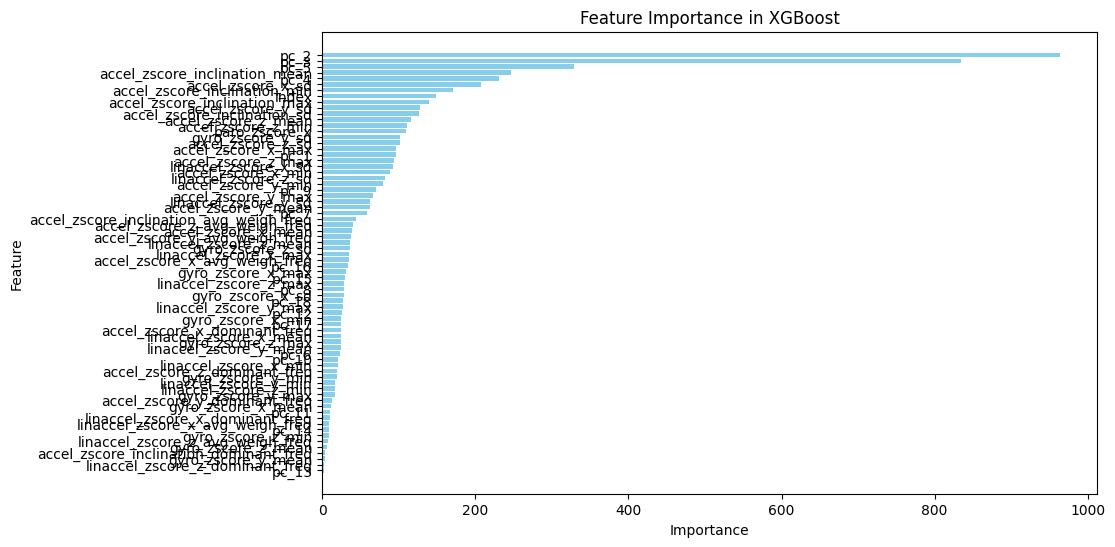

In [32]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost')
plt.gca().invert_yaxis()
plt.show()


GBM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Load the dataset
full_data = pd.read_parquet("/content/drive/MyDrive/ml4qs/full_dataset.parquet.gzip")

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in full_data.columns if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the model with default hyperparameters
default_gbm = GradientBoostingClassifier(random_state=42)
default_gbm.fit(X_train, y_train_encoded)

# Make predictions
y_pred = default_gbm.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print("Performance with Default Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Feature importance
importances = default_gbm.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Machines with Default Hyperparameters')
plt.gca().invert_yaxis()
plt.show()


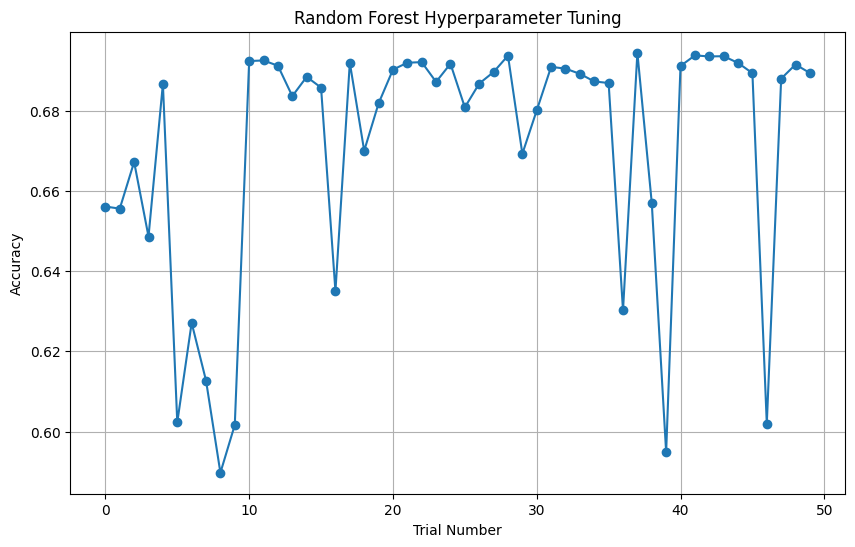

In [ ]:
import matplotlib.pyplot as plt

# Simulate the trials data based on the given output (for demonstration purposes)
trials_data = [
    (0, 0.6560796264713283), (1, 0.6555484105460341), (2, 0.6671792434366874), (3, 0.6485866860513881),
    (4, 0.6866385215422037), (5, 0.6022870243520564), (6, 0.6270864204434256), (7, 0.6126876729946599),
    (8, 0.5897335532753656), (9, 0.6016439734951212), (10, 0.6923421030558895), (11, 0.6924818967204406),
    (12, 0.6911678362736601), (13, 0.6835910196549893), (14, 0.6883999217155479), (15, 0.6857158833561663),
    (16, 0.6349707831241088), (17, 0.6919227220622362), (18, 0.6699751167277099), (19, 0.6817737020158247),
    (20, 0.6901892806218022), (21, 0.6919227220622362), (22, 0.6920625157267872), (23, 0.6871417787345877),
    (24, 0.6916710934660442), (25, 0.6807951463639668), (26, 0.6867223977409344), (27, 0.6896021472306875),
    (28, 0.6936841222355803), (29, 0.6692202309391339), (30, 0.6800402605753907), (31, 0.6908882489445578),
    (32, 0.6904409092179943), (33, 0.689154807504124), (34, 0.6872536136662286), (35, 0.6868621914054855),
    (36, 0.6301898397964604), (37, 0.6944110492912461), (38, 0.6569743059244555), (39, 0.5948500013979366),
    (40, 0.6911119188078396), (41, 0.6937400397014007), (42, 0.6934884111052088), (43, 0.6935443285710292),
    (44, 0.6918668045964157), (45, 0.6893225599015853), (46, 0.6019515195571337), (47, 0.6879525819889842),
    (48, 0.6914753823356725), (49, 0.6893505186344955)
]

# Extract trial numbers and values
trial_numbers, values = zip(*trials_data)

# Plotting the optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, values, marker='o')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


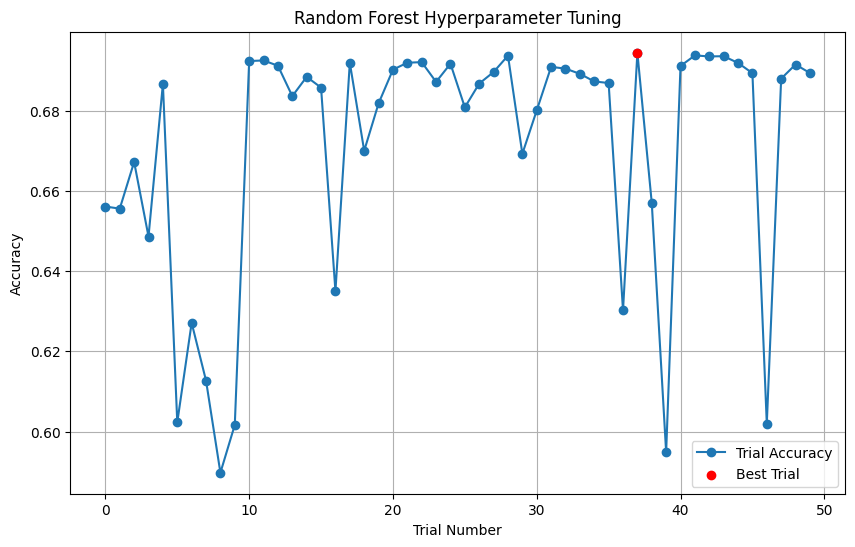

In [ ]:
import matplotlib.pyplot as plt

# Simulate the trials data based on the given output for Random Forest
trials_data_rf = [
    (0, 0.6560796264713283), (1, 0.6555484105460341), (2, 0.6671792434366874), (3, 0.6485866860513881),
    (4, 0.6866385215422037), (5, 0.6022870243520564), (6, 0.6270864204434256), (7, 0.6126876729946599),
    (8, 0.5897335532753656), (9, 0.6016439734951212), (10, 0.6923421030558895), (11, 0.6924818967204406),
    (12, 0.6911678362736601), (13, 0.6835910196549893), (14, 0.6883999217155479), (15, 0.6857158833561663),
    (16, 0.6349707831241088), (17, 0.6919227220622362), (18, 0.6699751167277099), (19, 0.6817737020158247),
    (20, 0.6901892806218022), (21, 0.6919227220622362), (22, 0.6920625157267872), (23, 0.6871417787345877),
    (24, 0.6916710934660442), (25, 0.6807951463639668), (26, 0.6867223977409344), (27, 0.6896021472306875),
    (28, 0.6936841222355803), (29, 0.6692202309391339), (30, 0.6800402605753907), (31, 0.6908882489445578),
    (32, 0.6904409092179943), (33, 0.689154807504124), (34, 0.6872536136662286), (35, 0.6868621914054855),
    (36, 0.6301898397964604), (37, 0.6944110492912461), (38, 0.6569743059244555), (39, 0.5948500013979366),
    (40, 0.6911119188078396), (41, 0.6937400397014007), (42, 0.6934884111052088), (43, 0.6935443285710292),
    (44, 0.6918668045964157), (45, 0.6893225599015853), (46, 0.6019515195571337), (47, 0.6879525819889842),
    (48, 0.6914753823356725), (49, 0.6893505186344955)
]

# Extract trial numbers and values
trial_numbers_rf, values_rf = zip(*trials_data_rf)

# Find the best trial (highest accuracy)
best_trial_index_rf = values_rf.index(max(values_rf))
best_trial_value_rf = max(values_rf)

# Plotting the optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers_rf, values_rf, marker='o', label='Trial Accuracy')
plt.scatter(best_trial_index_rf, best_trial_value_rf, color='red', zorder=5, label='Best Trial')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


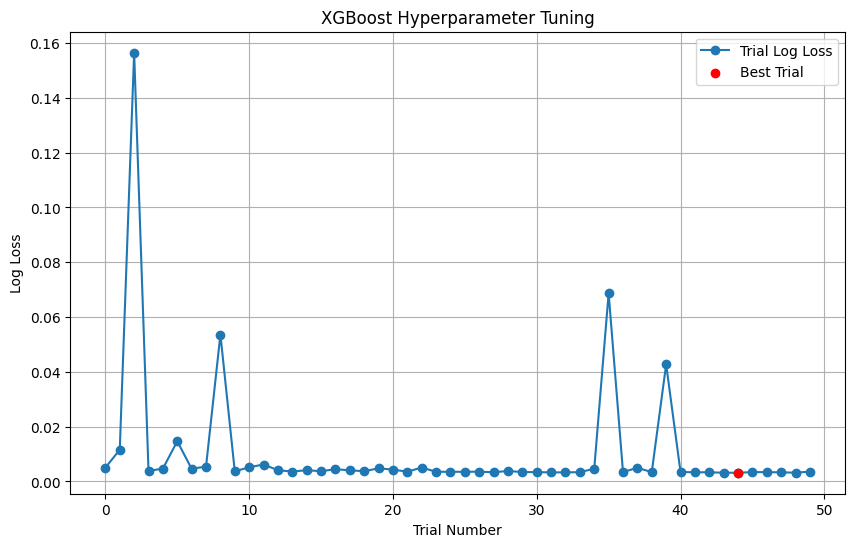

In [ ]:
import matplotlib.pyplot as plt

# Simulate the trials data based on the given output for XGBoost (for demonstration purposes)
trials_data_xgb = [
    (0, 0.0050507832099634655), (1, 0.011585200590160428), (2, 0.15644531325104244), (3, 0.003801919301716884),
    (4, 0.0047220243361594865), (5, 0.014690032957569729), (6, 0.004616372519922318), (7, 0.005459787117075532),
    (8, 0.053586640743222315), (9, 0.0037004394095707764), (10, 0.005189007477426284), (11, 0.00619142379170575),
    (12, 0.0041150516632049395), (13, 0.0036173648053466484), (14, 0.004126629766605454), (15, 0.0037517628041553223),
    (16, 0.004486737033458532), (17, 0.004061232303439599), (18, 0.0037677412236700415), (19, 0.004789572399822016),
    (20, 0.004326339690263422), (21, 0.003585874413694868), (22, 0.005072312796384233), (23, 0.003551176115709416),
    (24, 0.003532676920499476), (25, 0.0035362411784850903), (26, 0.0035798057031829157), (27, 0.0033651657271493384),
    (28, 0.0038371311058486082), (29, 0.0034396839219997476), (30, 0.0034032078819221526), (31, 0.0033205976425699896),
    (32, 0.0033274351161551078), (33, 0.0033976139440563464), (34, 0.004675037278208102), (35, 0.06866774596974642),
    (36, 0.0034320811720943136), (37, 0.005004088247650725), (38, 0.003412299407434988), (39, 0.0427274344401095),
    (40, 0.003474933694977672), (41, 0.003351839269638306), (42, 0.0033521070594251918), (43, 0.0032026697028255066),
    (44, 0.003196855269895142), (45, 0.00342131414691655), (46, 0.003408812744511336), (47, 0.003338250749145516),
    (48, 0.0032124352613627145), (49, 0.0036040479655562382)
]

# Extract trial numbers and values
trial_numbers_xgb, values_xgb = zip(*trials_data_xgb)

# Find the best trial
best_trial_index = values_xgb.index(min(values_xgb))
best_trial_value = min(values_xgb)

# Plotting the optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers_xgb, values_xgb, marker='o', label='Trial Log Loss')
plt.scatter(best_trial_index, best_trial_value, color='red', zorder=5, label='Best Trial')
plt.title('XGBoost Hyperparameter Tuning')
plt.xlabel('Trial Number')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend()
plt.show()


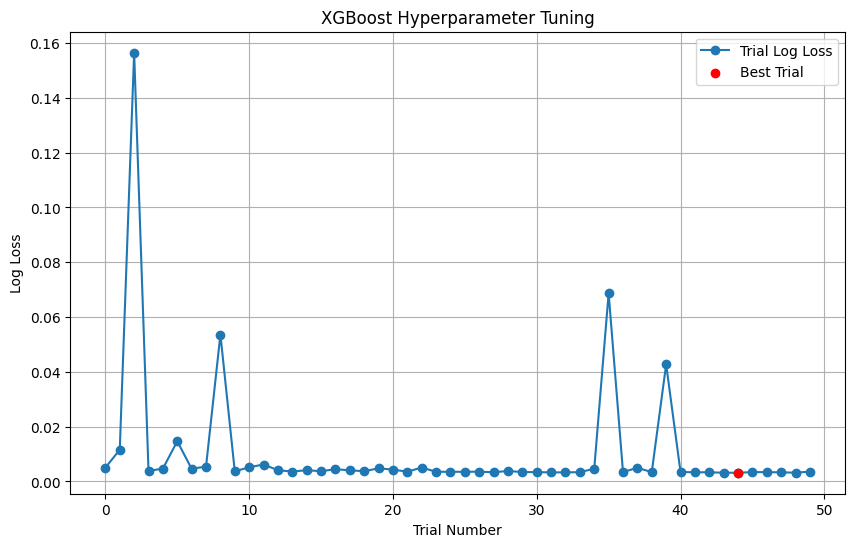

In [ ]:
import matplotlib.pyplot as plt

# Simulate the trials data based on the given output for XGBoost
trials_data_xgb = [
    (0, 0.0050507832099634655), (1, 0.011585200590160428), (2, 0.15644531325104244), (3, 0.003801919301716884),
    (4, 0.0047220243361594865), (5, 0.014690032957569729), (6, 0.004616372519922318), (7, 0.005459787117075532),
    (8, 0.053586640743222315), (9, 0.0037004394095707764), (10, 0.005189007477426284), (11, 0.00619142379170575),
    (12, 0.0041150516632049395), (13, 0.0036173648053466484), (14, 0.004126629766605454), (15, 0.0037517628041553223),
    (16, 0.004486737033458532), (17, 0.004061232303439599), (18, 0.0037677412236700415), (19, 0.004789572399822016),
    (20, 0.004326339690263422), (21, 0.003585874413694868), (22, 0.005072312796384233), (23, 0.003551176115709416),
    (24, 0.003532676920499476), (25, 0.0035362411784850903), (26, 0.0035798057031829157), (27, 0.0033651657271493384),
    (28, 0.0038371311058486082), (29, 0.0034396839219997476), (30, 0.0034032078819221526), (31, 0.0033205976425699896),
    (32, 0.0033274351161551078), (33, 0.0033976139440563464), (34, 0.004675037278208102), (35, 0.06866774596974642),
    (36, 0.0034320811720943136), (37, 0.005004088247650725), (38, 0.003412299407434988), (39, 0.0427274344401095),
    (40, 0.003474933694977672), (41, 0.003351839269638306), (42, 0.0033521070594251918), (43, 0.0032026697028255066),
    (44, 0.003196855269895142), (45, 0.00342131414691655), (46, 0.003408812744511336), (47, 0.003338250749145516),
    (48, 0.0032124352613627145), (49, 0.0036040479655562382)
]

# Extract trial numbers and values
trial_numbers_xgb, values_xgb = zip(*trials_data_xgb)

# Find the best trial
best_trial_index = values_xgb.index(min(values_xgb))
best_trial_value = min(values_xgb)

# Plotting the optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers_xgb, values_xgb, marker='o', label='Trial Log Loss')
plt.scatter(best_trial_index, best_trial_value, color='red', zorder=5, label='Best Trial')
plt.title('XGBoost Hyperparameter Tuning')
plt.xlabel('Trial Number')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend()
plt.show()


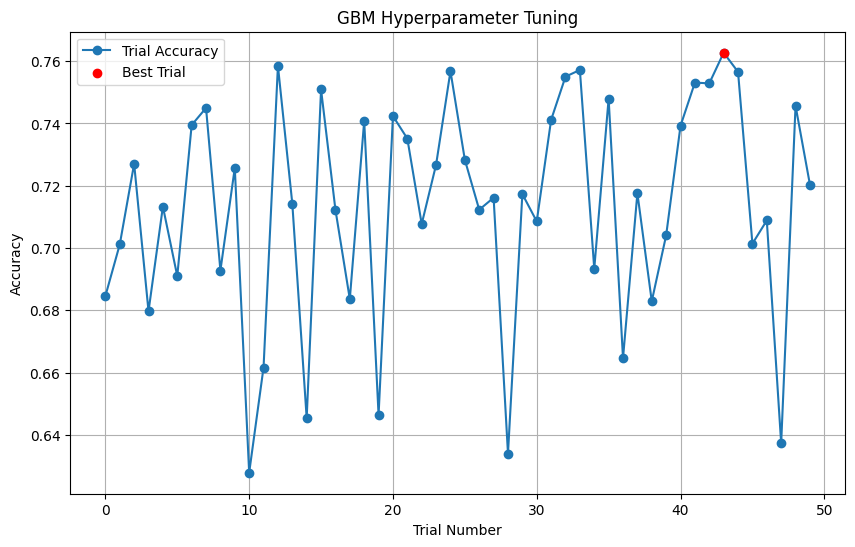

In [ ]:
import matplotlib.pyplot as plt

# Simulate the trials data based on the given output for GBM
trials_data_gbm = [
    (0, 0.6845975340397573), (1, 0.7011491039226102), (2, 0.7270668493303883), (3, 0.6797047557804681),
    (4, 0.7133111527385579), (5, 0.6910000838761987), (6, 0.7394805267425281), (7, 0.7449883971258423),
    (8, 0.6927894427824531), (9, 0.7257248301506976), (10, 0.6278692649649118), (11, 0.661643414320463),
    (12, 0.7584924651214807), (13, 0.7142897083904157), (14, 0.6453714317667123), (15, 0.7509156485028099),
    (16, 0.7123046383537898), (17, 0.6836189783878994), (18, 0.7408225459222189), (19, 0.6463779461514804),
    (20, 0.7423882349651914), (21, 0.7351469231414433), (22, 0.707719406156513), (23, 0.7267593032683759),
    (24, 0.756786982413957), (25, 0.7283529510442587), (26, 0.7123046383537898), (27, 0.7161629434954008),
    (28, 0.6340201862051612), (29, 0.7173372102776302), (30, 0.7085581681438197), (31, 0.7411580507171415),
    (32, 0.7550255822406129), (33, 0.7571784046747001), (34, 0.6933486174406576), (35, 0.747952022814326),
    (36, 0.664634998741857), (37, 0.7176167976067325), (38, 0.6829200100651438), (39, 0.7040568121452736),
    (40, 0.7392568568792462), (41, 0.7531243884027176), (42, 0.7528727598065256), (43, 0.7627142337909246),
    (44, 0.7565633125506752), (45, 0.7014007325188022), (46, 0.7088657142058322), (47, 0.6373193166885677),
    (48, 0.7456873654485978), (49, 0.7203847121648447)
]

# Extract trial numbers and values
trial_numbers_gbm, values_gbm = zip(*trials_data_gbm)

# Find the best trial (highest accuracy)
best_trial_index_gbm = values_gbm.index(max(values_gbm))
best_trial_value_gbm = max(values_gbm)

# Plotting the optimization history
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers_gbm, values_gbm, marker='o', label='Trial Accuracy')
plt.scatter(best_trial_index_gbm, best_trial_value_gbm, color='red', zorder=5, label='Best Trial')
plt.title('GBM Hyperparameter Tuning')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


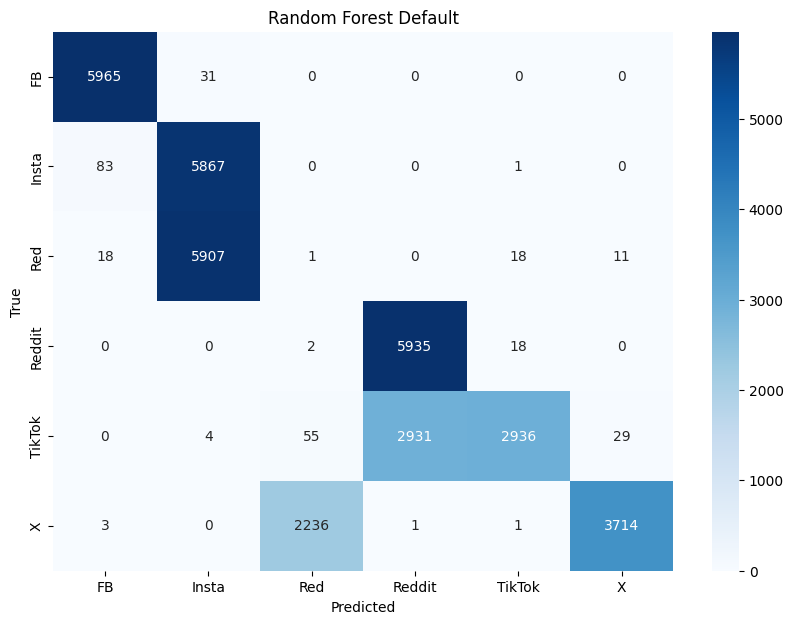

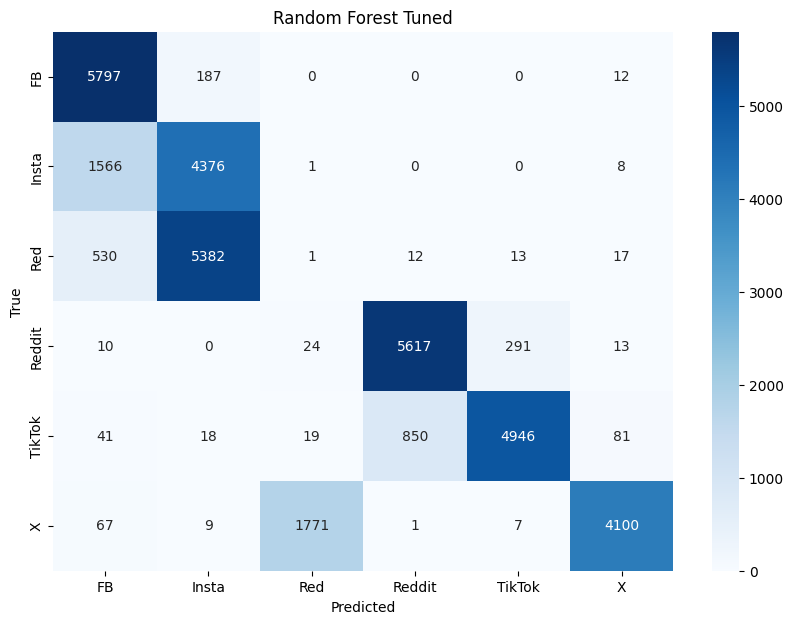

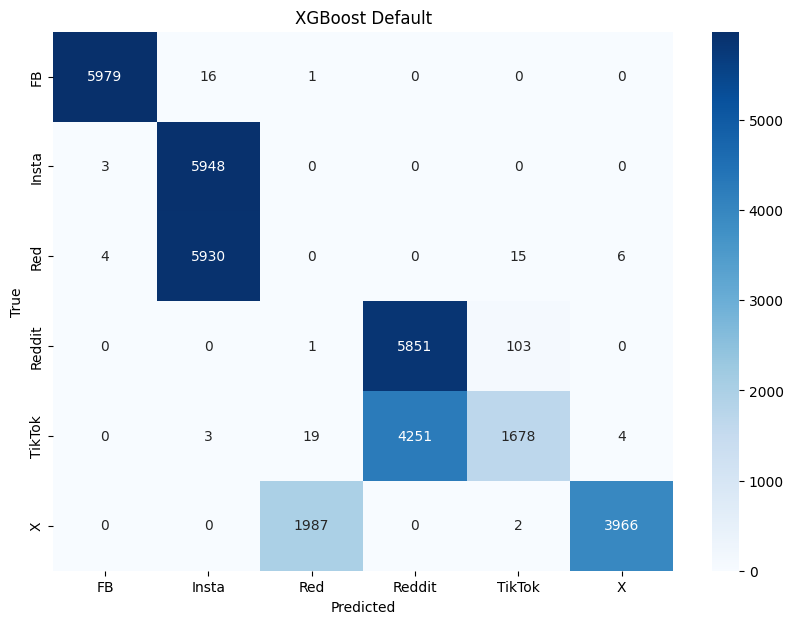

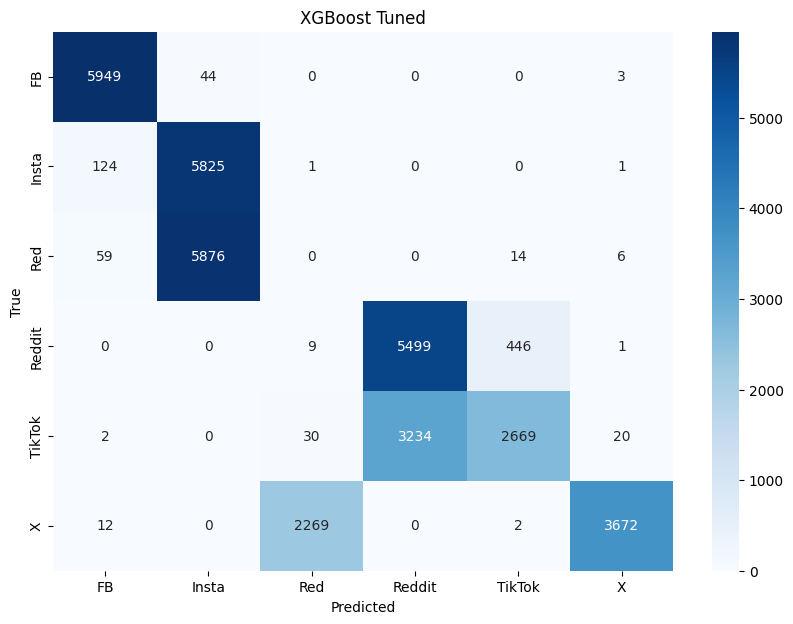

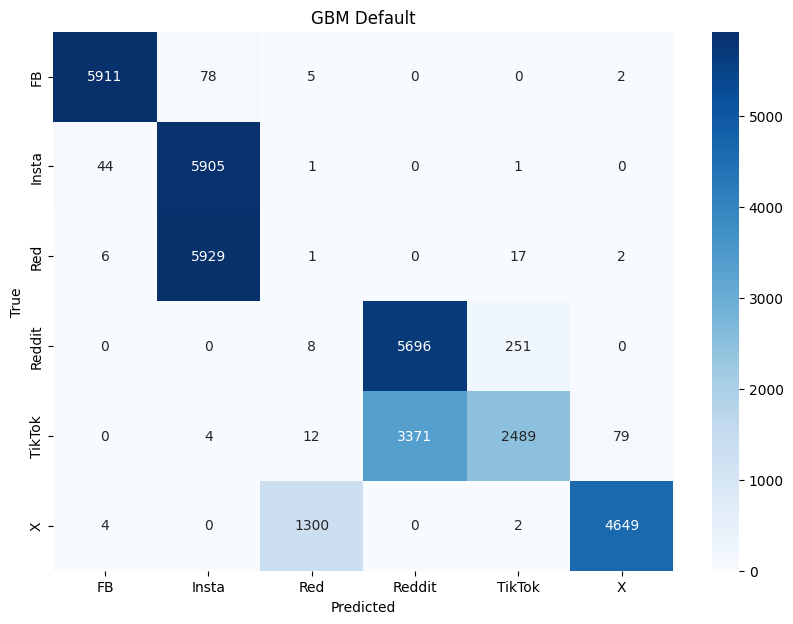

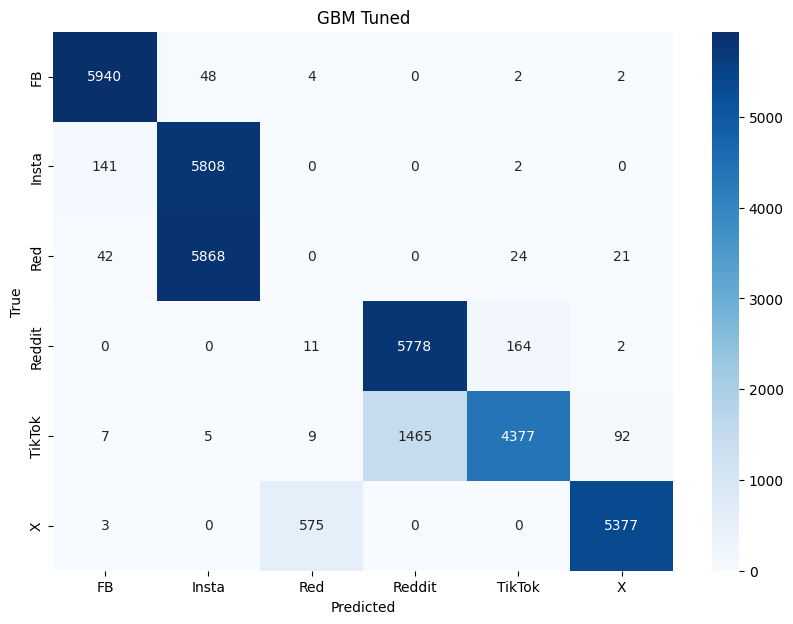

           Model Hyperparameters  Accuracy
0  Random Forest         Default  0.682696
1  Random Forest           Tuned  0.694411
2        XGBoost         Default  0.654849
3        XGBoost           Tuned  0.660218
4            GBM         Default  0.689211
5            GBM           Tuned  0.762714

\begin{table}[ht]
\centering
\begin{tabular}{lll}
\hline
Model & Hyperparameters & Accuracy \\
\hline
Random Forest & Default & 0.6827 \\
Random Forest & Tuned & 0.6944 \\
XGBoost & Default & 0.6548 \\
XGBoost & Tuned & 0.6602 \\
GBM & Default & 0.6892 \\
GBM & Tuned & 0.7627 \\
\hline
\end{tabular}
\caption{Comparison of Model Performance Before and After Tuning}
\end{table}



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Data for Random Forest
rf_labels = ["FB", "Insta", "Red", "Reddit", "TikTok", "X"]
rf_cm_default = np.array([[5965, 31, 0, 0, 0, 0],
                          [83, 5867, 0, 0, 1, 0],
                          [18, 5907, 1, 0, 18, 11],
                          [0, 0, 2, 5935, 18, 0],
                          [0, 4, 55, 2931, 2936, 29],
                          [3, 0, 2236, 1, 1, 3714]])

rf_cm_tuned = np.array([[5797, 187, 0, 0, 0, 12],
                        [1566, 4376, 1, 0, 0, 8],
                        [530, 5382, 1, 12, 13, 17],
                        [10, 0, 24, 5617, 291, 13],
                        [41, 18, 19, 850, 4946, 81],
                        [67, 9, 1771, 1, 7, 4100]])

# Data for XGBoost
xgb_labels = ["FB", "Insta", "Red", "Reddit", "TikTok", "X"]
xgb_cm_default = np.array([[5979, 16, 1, 0, 0, 0],
                           [3, 5948, 0, 0, 0, 0],
                           [4, 5930, 0, 0, 15, 6],
                           [0, 0, 1, 5851, 103, 0],
                           [0, 3, 19, 4251, 1678, 4],
                           [0, 0, 1987, 0, 2, 3966]])

xgb_cm_tuned = np.array([[5949, 44, 0, 0, 0, 3],
                         [124, 5825, 1, 0, 0, 1],
                         [59, 5876, 0, 0, 14, 6],
                         [0, 0, 9, 5499, 446, 1],
                         [2, 0, 30, 3234, 2669, 20],
                         [12, 0, 2269, 0, 2, 3672]])

# Data for GBM
gbm_labels = ["FB", "Insta", "Red", "Reddit", "TikTok", "X"]
gbm_cm_default = np.array([[5911, 78, 5, 0, 0, 2],
                           [44, 5905, 1, 0, 1, 0],
                           [6, 5929, 1, 0, 17, 2],
                           [0, 0, 8, 5696, 251, 0],
                           [0, 4, 12, 3371, 2489, 79],
                           [4, 0, 1300, 0, 2, 4649]])

gbm_cm_tuned = np.array([[5940, 48, 4, 0, 2, 2],
                         [141, 5808, 0, 0, 2, 0],
                         [42, 5868, 0, 0, 24, 21],
                         [0, 0, 11, 5778, 164, 2],
                         [7, 5, 9, 1465, 4377, 92],
                         [3, 0, 575, 0, 0, 5377]])

# Plotting confusion matrices
plot_confusion_matrix(rf_cm_default, rf_labels, 'Random Forest Default')
plot_confusion_matrix(rf_cm_tuned, rf_labels, 'Random Forest Tuned')
plot_confusion_matrix(xgb_cm_default, xgb_labels, 'XGBoost Default')
plot_confusion_matrix(xgb_cm_tuned, xgb_labels, 'XGBoost Tuned')
plot_confusion_matrix(gbm_cm_default, gbm_labels, 'GBM Default')
plot_confusion_matrix(gbm_cm_tuned, gbm_labels, 'GBM Tuned')

# Creating tables for comparison
comparison_data = {
    'Model': ['Random Forest', 'Random Forest', 'XGBoost', 'XGBoost', 'GBM', 'GBM'],
    'Hyperparameters': ['Default', 'Tuned', 'Default', 'Tuned', 'Default', 'Tuned'],
    'Accuracy': [0.6826963402018621, 0.6944110492912461, 0.6548494422232785, 0.6602175189420415, 0.6892107249699444, 0.7627142337909246]
}

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

# LaTeX code for table
comparison_table = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{lll}
\\hline
Model & Hyperparameters & Accuracy \\\\
\\hline
Random Forest & Default & 0.6827 \\\\
Random Forest & Tuned & 0.6944 \\\\
XGBoost & Default & 0.6548 \\\\
XGBoost & Tuned & 0.6602 \\\\
GBM & Default & 0.6892 \\\\
GBM & Tuned & 0.7627 \\\\
\\hline
\\end{tabular}
\\caption{Comparison of Model Performance Before and After Tuning}
\\end{table}
"""

print(comparison_table)
